In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.metrics import mean_squared_error

plt.style.use("fivethirtyeight")

In [36]:
# Read in data
df = pd.read_csv("PJME_hourly.csv", parse_dates=True, index_col="Datetime")
df.head()

,PJME_MW
Datetime,
2002-12-31 01:00:00,26498.0
2002-12-31 02:00:00,25147.0
2002-12-31 03:00:00,24574.0
2002-12-31 04:00:00,24393.0
2002-12-31 05:00:00,24860.0


In [37]:
df.tail()

,PJME_MW
Datetime,
2018-01-01 20:00:00,44284.0
2018-01-01 21:00:00,43751.0
2018-01-01 22:00:00,42402.0
2018-01-01 23:00:00,40164.0
2018-01-02 00:00:00,38608.0


### Define Colour palette

In [38]:
colour_palette = sns.color_palette(palette="bright")

In [39]:
colour_palette

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

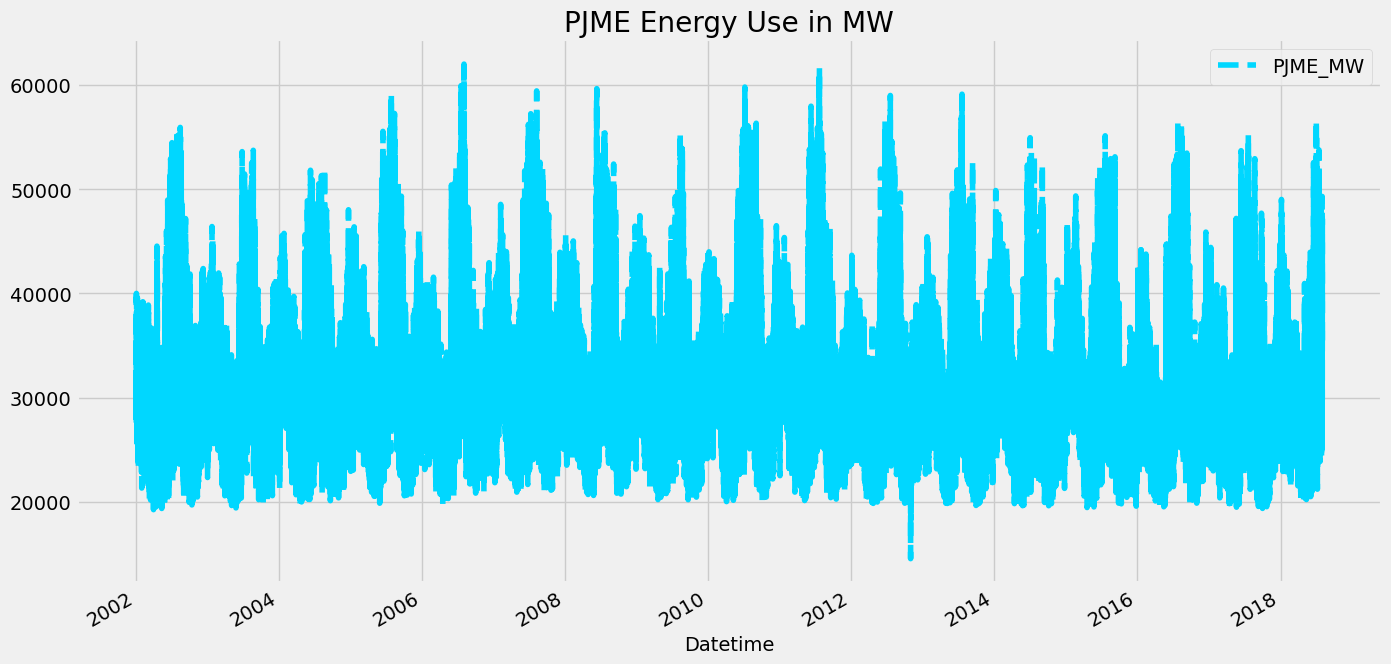

In [40]:
df.plot(style = '--', figsize = (15, 8), color = colour_palette[9], title = "PJME Energy Use in MW");

# Train Test Split

In [41]:
train = df[df.index < "01-01-2015"]
test = df[df.index >= "01-01-2015"]

In [42]:
print(df.shape)
print(train.shape)
print(test.shape)

(145366, 1)
(113926, 1)
(31440, 1)


In [43]:
from datetime import datetime

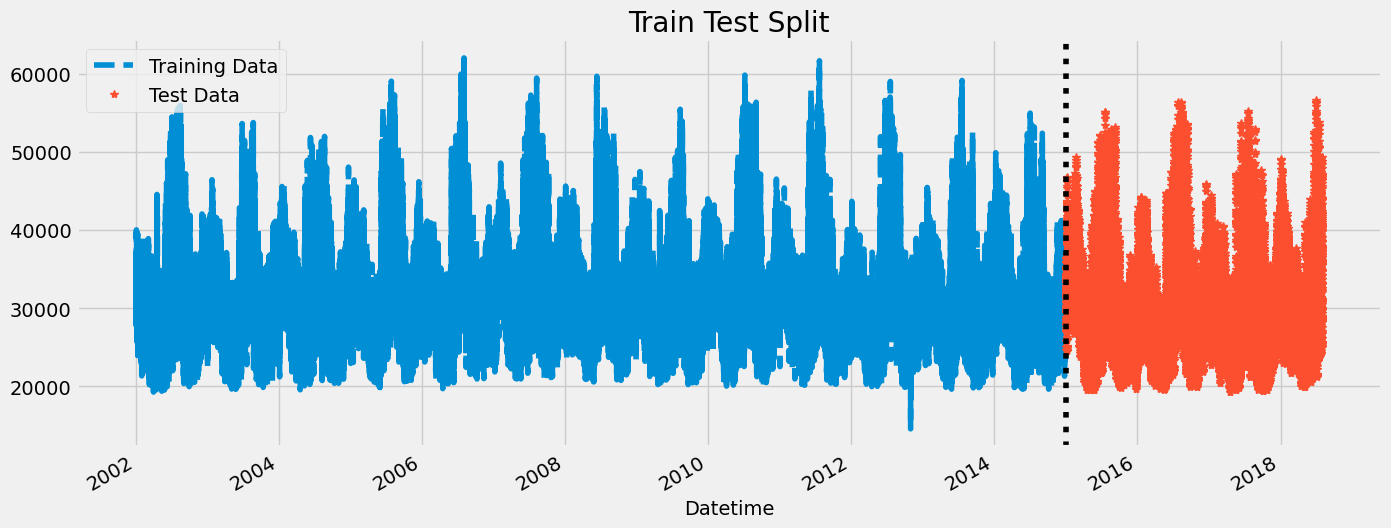

In [44]:
# Visualise train-test split
fig, ax = plt.subplots(figsize = (15,6))

train["PJME_MW"].plot(ax = ax, label = "Training Set", title = "Train Test Split", style = "--")
test["PJME_MW"].plot(ax = ax, label = "Test Set", style = "*")
ax.axvline(x = datetime(2015,1,1), color = "black", ls = ":")
ax.legend(["Training Data", "Test Data"]);

## EDA

<Axes: title={'center': 'Randomly Selected Weekly Consumption'}, xlabel='Datetime'>

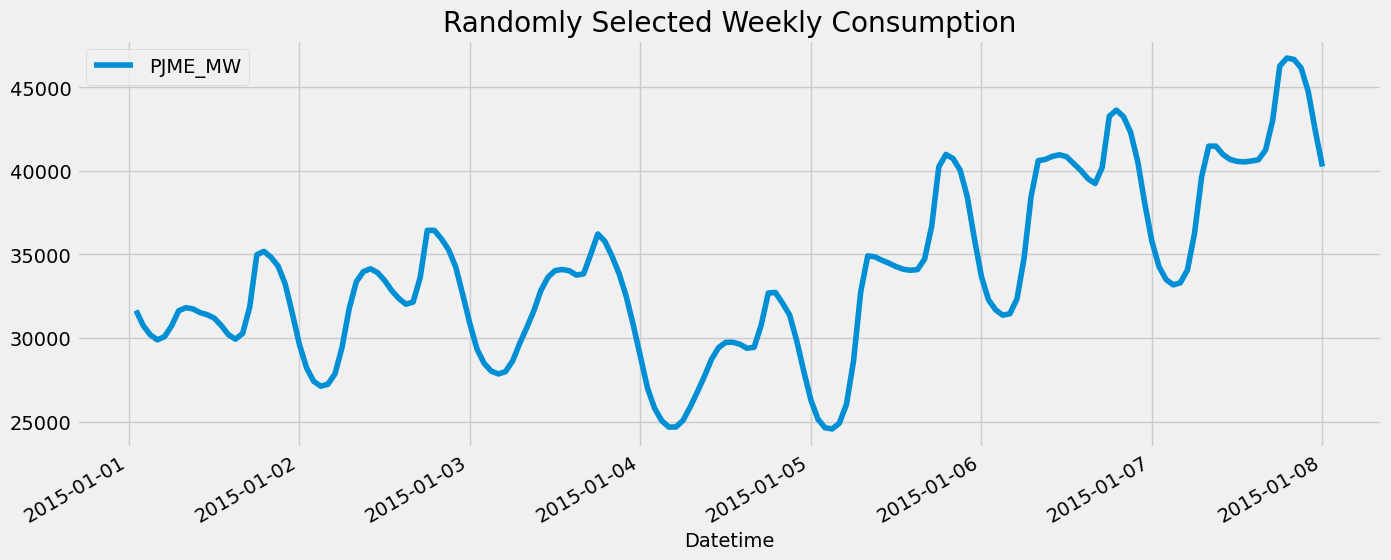

In [45]:
df[(df.index > '01-01-2015') & (df.index <= '01-08-2015')].plot(
    figsize = (15,6), 
    title = "Randomly Selected Weekly Consumption"
)

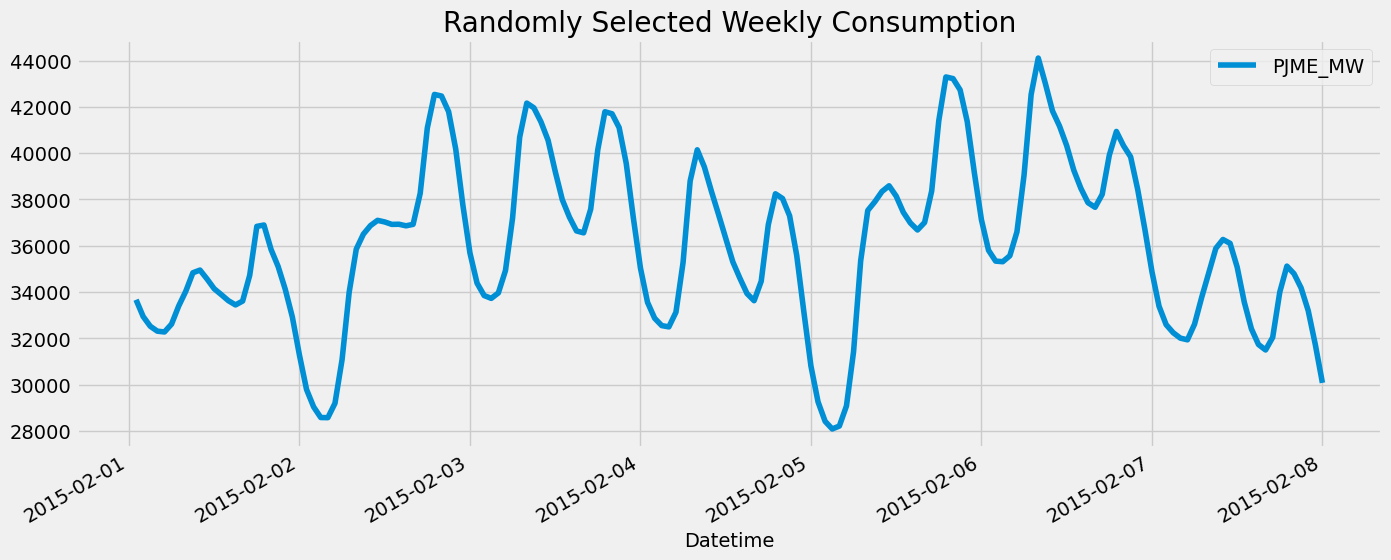

In [46]:
df[(df.index > '02-01-2015') & (df.index <= '02-08-2015')].plot(
    figsize = (15,6), 
    title = "Randomly Selected Weekly Consumption"
);

# Feature Creation

In [47]:
def create_features(df1):
    """
    Create time series features from time series index
    """
    df1 = df1.copy()
    df1['hour'] = df1.index.hour
    df1["dayofweek"] = df1.index.dayofweek
    df1["quarter"] = df1.index.quarter
    df1["month"] = df1.index.month
    df1["year"] = df1.index.year
    df1["dayofyear"] = df1.index.dayofyear
    return df1

In [48]:
df = create_features(df)
df.head()


,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [49]:
train = create_features(train)
test = create_features(test)

## Explore created features

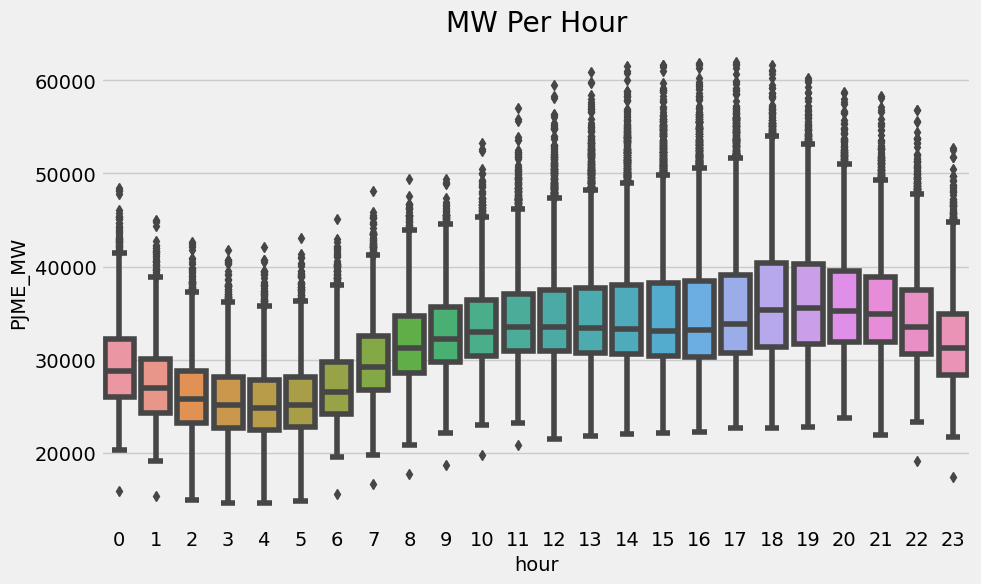

In [50]:
fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data = df, x = "hour", y = "PJME_MW", ax = ax)
ax.set_title("MW Per Hour");

Peak use time is between 10am and 10pm

Text(0.5, 1.0, 'MW Per Month')

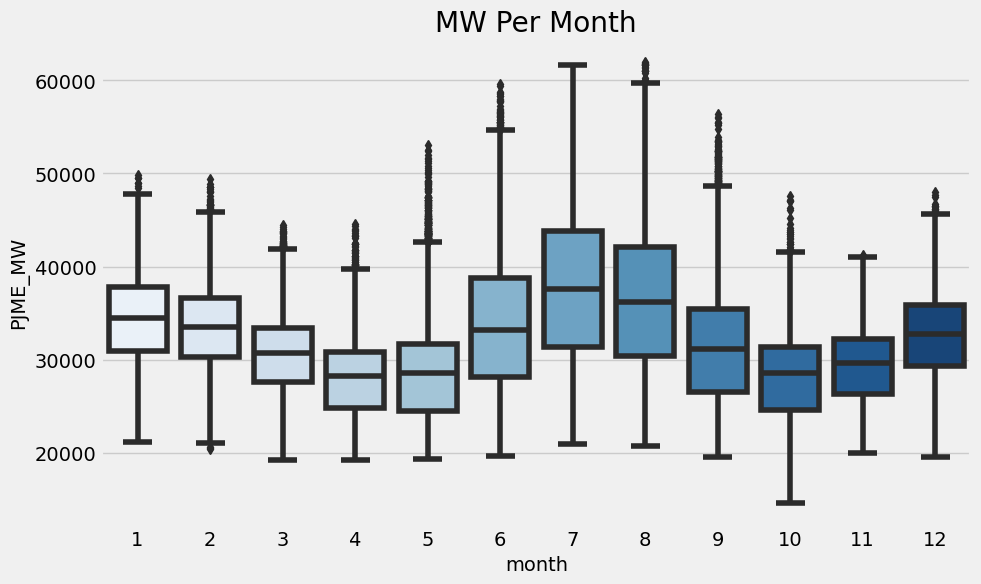

In [51]:
fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data = df, x = "month", y = "PJME_MW", ax = ax, palette="Blues")
ax.set_title("MW Per Month")

Looking at the monthly timeframe, the MegaWatts usage peaks twice: 
1. During winter: This can be attributed to use of the room heater
2. During the summer: This can be attributed to use of Air Conditioning during this season 

Text(0.5, 1.0, 'MW Per Day of the Week')

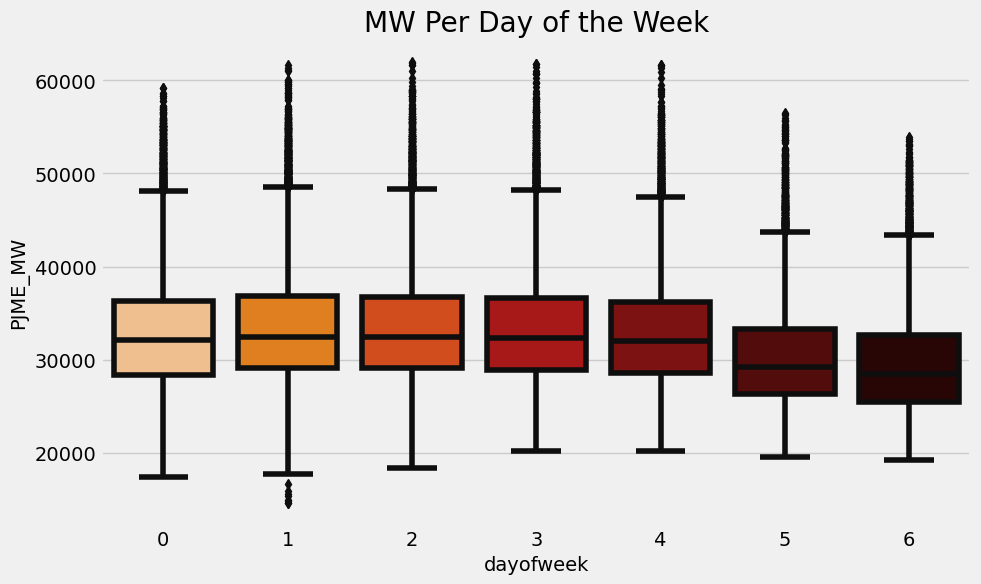

In [52]:
fig, ax = plt.subplots(figsize = (10,6))
sns.boxplot(data = df, x = "dayofweek", y = "PJME_MW", ax = ax, palette="gist_heat_r")
ax.set_title("MW Per Day of the Week")

# Feature Matrix and Target Vector

In [53]:
df.columns

Index(['PJME_MW', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear'],
      dtype='object')

In [54]:
features = ['dayofweek', 'quarter', 'month', 'year', 'dayofyear','hour']
target = "PJME_MW"

In [55]:
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test =test[target]

# Build Model

In [56]:
model = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, learning_rate = 0.01)
model.fit(X_train, y_train, eval_set = [(X_train, y_train),(X_test, y_test)])

[0]	validation_0-rmse:32601.87826	validation_1-rmse:31654.28935
[1]	validation_0-rmse:32279.88735	validation_1-rmse:31332.60350


[2]	validation_0-rmse:31961.14360	validation_1-rmse:31014.27357
[3]	validation_0-rmse:31645.62525	validation_1-rmse:30699.10021
[4]	validation_0-rmse:31333.30788	validation_1-rmse:30385.92606
[5]	validation_0-rmse:31024.14316	validation_1-rmse:30075.82644
[6]	validation_0-rmse:30718.10796	validation_1-rmse:29769.05547
[7]	validation_0-rmse:30415.17979	validation_1-rmse:29465.13991
[8]	validation_0-rmse:30115.31200	validation_1-rmse:29164.62813
[9]	validation_0-rmse:29818.48171	validation_1-rmse:28866.85195
[10]	validation_0-rmse:29524.66621	validation_1-rmse:28571.74321
[11]	validation_0-rmse:29233.82326	validation_1-rmse:28280.36822
[12]	validation_0-rmse:28945.84627	validation_1-rmse:27991.30072
[13]	validation_0-rmse:28660.79476	validation_1-rmse:27705.25177
[14]	validation_0-rmse:28378.63481	validation_1-rmse:27422.93836
[15]	validation_0-rmse:28099.33234	validation_1-rmse:27143.92463
[16]	validation_0-rmse:27822.84964	validation_1-rmse:26868.12184
[17]	validation_0-rmse:27549.1816

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

# Feature Importance

<Axes: title={'center': 'Feature Importance'}>

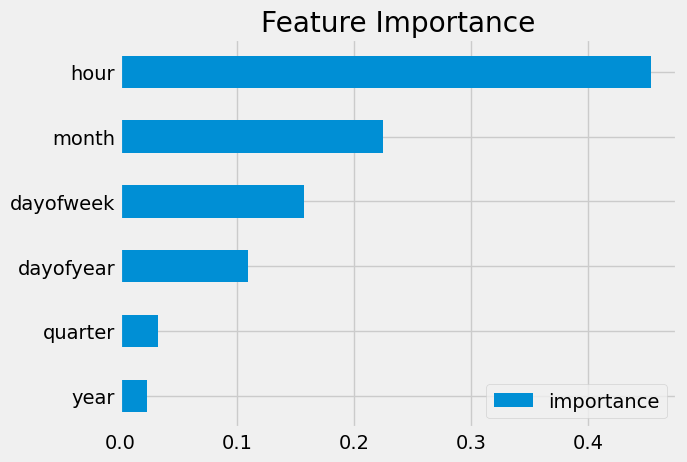

In [57]:
# Obtain feature importances
pd.DataFrame(data = model.feature_importances_,
             index=model.feature_names_in_, 
             columns=["importance"])\
.sort_values("importance")\
.plot(kind = "barh", title = "Feature Importance")

# Forecasting on Test Set

In [58]:
test["prediction"]= model.predict(X_test)

In [59]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear
Datetime,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365


In [60]:
df = df.merge(test["prediction"], how = "left", on = "Datetime")

In [61]:
df.head()

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction
Datetime,,,,,,,,
2002-12-31 01:00:00,26498.0,1,1,4,12,2002,365,NaN
2002-12-31 02:00:00,25147.0,2,1,4,12,2002,365,NaN
2002-12-31 03:00:00,24574.0,3,1,4,12,2002,365,NaN
2002-12-31 04:00:00,24393.0,4,1,4,12,2002,365,NaN
2002-12-31 05:00:00,24860.0,5,1,4,12,2002,365,NaN


Text(0.5, 1.0, 'Raw Data and Predictions')

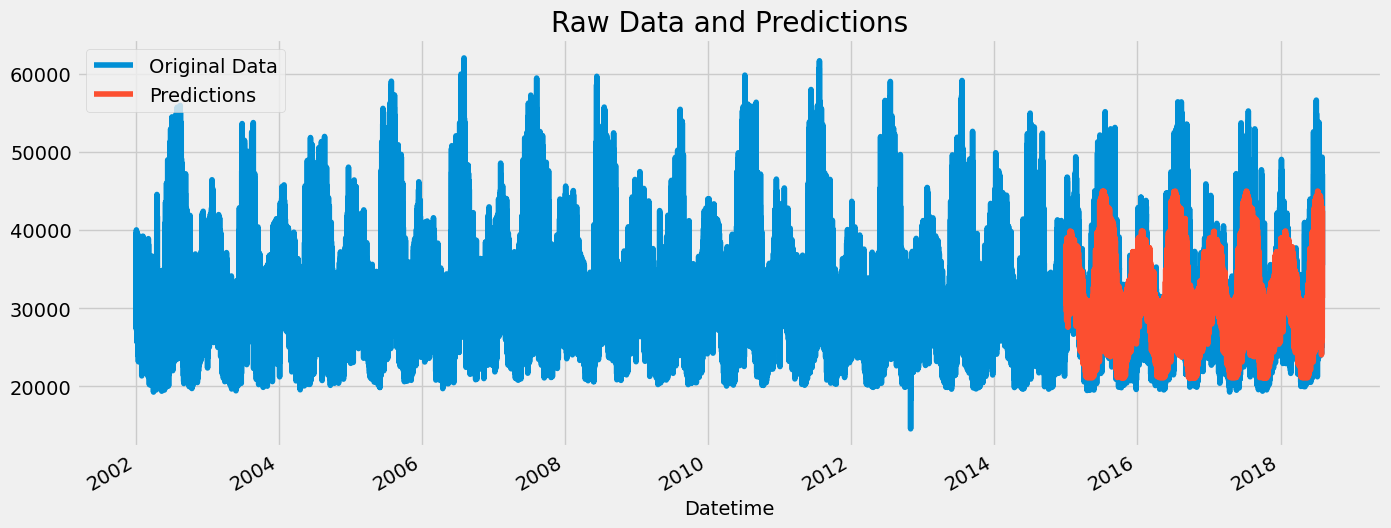

In [62]:
fig, ax = plt.subplots(figsize = (15,6))
df["PJME_MW"].plot(ax = ax)
df["prediction"].plot(ax = ax)
ax.legend(["Original Data", "Predictions"])
ax.set_title("Raw Data and Predictions")

In [64]:
mse_7_features = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(f"The MSE with the 7 features: {mse_7_features}")

3714.6734048384837

# Calculate Error

In [68]:
test["error"] = np.abs(y_test - model.predict(X_test))

In [69]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,error
Datetime,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32085.656250,716.343750
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28353.556641,4048.556641
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27241.048828,4085.048828
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26901.326172,4387.326172
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26901.326172,4571.326172
...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,36839.972656,7444.027344
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,36698.066406,7052.933594
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,34718.617188,7683.382812


In [71]:
test["date"] = test.index.date

In [72]:
test

,PJME_MW,hour,dayofweek,quarter,month,year,dayofyear,prediction,error,date
Datetime,,,,,,,,,,
2015-01-01 00:00:00,32802.0,0,3,1,1,2015,1,32085.656250,716.343750,2015-01-01
2015-12-31 01:00:00,24305.0,1,3,4,12,2015,365,28353.556641,4048.556641,2015-12-31
2015-12-31 02:00:00,23156.0,2,3,4,12,2015,365,27241.048828,4085.048828,2015-12-31
2015-12-31 03:00:00,22514.0,3,3,4,12,2015,365,26901.326172,4387.326172,2015-12-31
2015-12-31 04:00:00,22330.0,4,3,4,12,2015,365,26901.326172,4571.326172,2015-12-31
...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,44284.0,20,0,1,1,2018,1,36839.972656,7444.027344,2018-01-01
2018-01-01 21:00:00,43751.0,21,0,1,1,2018,1,36698.066406,7052.933594,2018-01-01
2018-01-01 22:00:00,42402.0,22,0,1,1,2018,1,34718.617188,7683.382812,2018-01-01


### Best Predictions

In [75]:
test.groupby(["date"])["error"].mean().sort_values().head(10)

date
2016-09-27    398.950033
2016-04-04    409.618571
2016-05-01    444.098633
2015-03-10    487.506999
2015-10-28    489.104736
2015-09-25    496.851237
2016-12-08    503.769775
2017-05-02    513.833822
2017-12-08    531.025146
2016-12-13    548.417074
Name: error, dtype: float64

### Worst Predictions

In [78]:
test.groupby(["date"])["error"].mean().sort_values(ascending = False).head(10)

date
2016-08-13    14565.235596
2016-08-14    14452.406901
2016-09-10    12445.566650
2016-08-12    11510.906982
2016-09-09    11307.930339
2015-02-20    10857.502441
2018-01-06    10705.862386
2016-08-11    10442.189941
2017-05-19    10145.722493
2018-01-07    10091.145589
Name: error, dtype: float64

## Retrain model with the top 4 most important features

In [68]:
top_4_feats = ['dayofweek', 'month', 'dayofyear','hour']

X_train_top4 = train[top_4_feats]
y_train_top4 = train[target]

X_test_top4 = test[top_4_feats]
y_test_top4 =test[target]

In [69]:
model_top4 = xgb.XGBRegressor(n_estimators = 500, early_stopping_rounds = 50, learning_rate = 0.01)
model_top4.fit(X_train_top4, y_train_top4, eval_set = [(X_train_top4, y_train_top4),(X_test_top4, y_test_top4)])

[0]	validation_0-rmse:32601.89957	validation_1-rmse:31654.13338
[1]	validation_0-rmse:32279.93064	validation_1-rmse:31332.29520
[2]	validation_0-rmse:31961.20786	validation_1-rmse:31013.73357
[3]	validation_0-rmse:31645.71029	validation_1-rmse:30698.42859
[4]	validation_0-rmse:31333.41433	validation_1-rmse:30386.29406
[5]	validation_0-rmse:31024.26984	validation_1-rmse:30077.36528
[6]	validation_0-rmse:30718.25493	validation_1-rmse:29771.54002
[7]	validation_0-rmse:30415.34754	validation_1-rmse:29468.86778
[8]	validation_0-rmse:30115.49974	validation_1-rmse:29169.26041
[9]	validation_0-rmse:29818.69798	validation_1-rmse:28872.71962
[10]	validation_0-rmse:29524.89433	validation_1-rmse:28579.17951
[11]	validation_0-rmse:29234.07189	validation_1-rmse:28288.65010
[12]	validation_0-rmse:28946.12362	validation_1-rmse:28001.05675
[13]	validation_0-rmse:28661.08374	validation_1-rmse:27716.36817
[14]	validation_0-rmse:28378.94693	validation_1-rmse:27434.62820
[15]	validation_0-rmse:28099.67351	

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

<Axes: title={'center': 'Feature Importance'}>

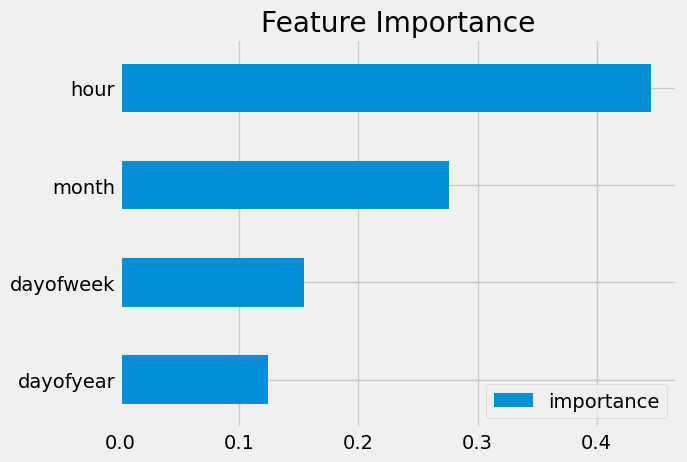

In [70]:
# Obtain feature importances
pd.DataFrame(data = model_top4.feature_importances_,
             index=model_top4.feature_names_in_, 
             columns=["importance"])\
.sort_values("importance")\
.plot(kind = "barh", title = "Feature Importance")

### Forecasting on test set

In [71]:
test["prediction_top4"]= model_top4.predict(X_test_top4)

In [72]:
df = df.merge(test["prediction_top4"], how = "left", on = "Datetime")

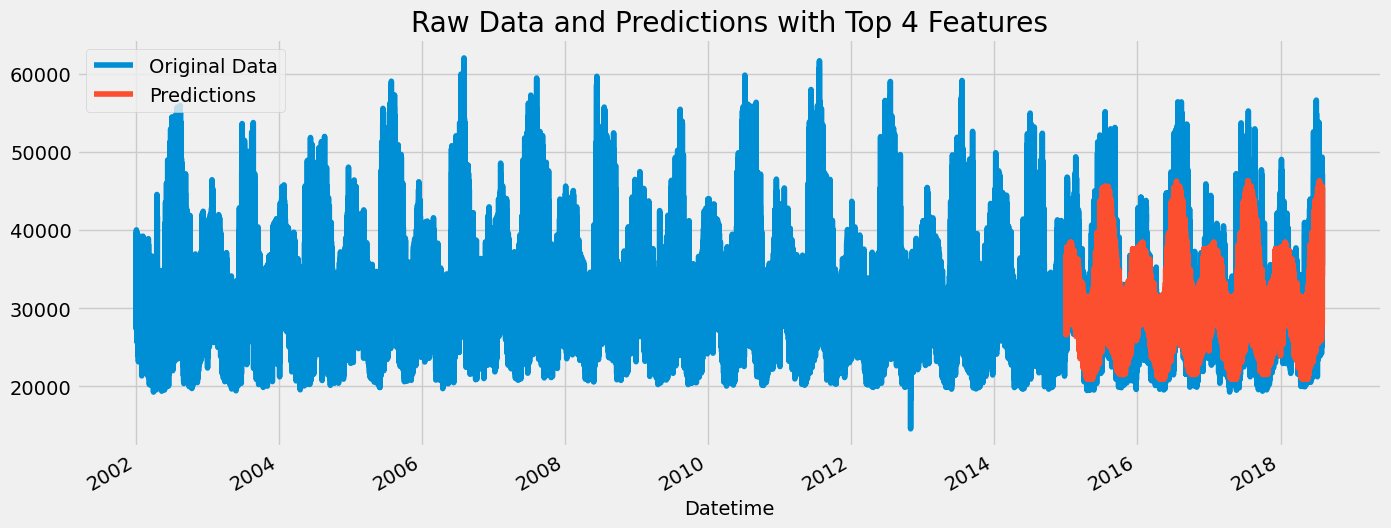

In [75]:
fig, ax = plt.subplots(figsize = (15,6))
df["PJME_MW"].plot(ax = ax)
df["prediction_top4"].plot(ax = ax)
ax.legend(["Original Data", "Predictions"])
ax.set_title("Raw Data and Predictions with Top 4 Features");

In [76]:
mse_top4 = np.sqrt(mean_squared_error(y_test_top4, model_top4.predict(X_test_top4)))
print(f"The MSE with the top 4 features: {mse_top4}")

The MSE with the top 4 features: 3596.2128847982417


### Comparing MSE of all 7 engineered features VS top 4 most important features (according to the model)

| | 7 Features | 4 Features |
|-----|------------|------------|
| MSE | $3714.67$ | $3596.21$ |